In [2]:
import pandas as pd 

data = pd.read_csv("../data/MLdata.csv")

data["Ship Date"] = pd.to_datetime(data["Ship Date"])
data["Order Date"] = pd.to_datetime(data["Order Date"])
data.head()

,Order Priority,Market,Segment,Category,Sub-Category,City,Country,Region,State,Ship Date,Order Date,Quantity,Discount,Sales,Shipping Cost,Ship Mode,Profit
0,Critical,US,Consumer,Technology,Accessories,New York City,United States,East,New York,2012-07-31,2012-07-31,7,0.0,2309.650,933.57,Same Day,762.1850
1,Critical,US,Consumer,Furniture,Tables,New York City,United States,East,New York,2012-07-31,2012-07-31,7,0.4,1090.780,348.18,Same Day,-290.8750
2,Critical,US,Consumer,Office Supplies,Paper,New York City,United States,East,New York,2012-07-31,2012-07-31,3,0.0,19.440,7.24,Same Day,9.3312
3,Critical,APAC,Corporate,Technology,Copiers,Wollongong,Australia,Oceania,New South Wales,2013-02-07,2013-02-05,2,0.1,344.682,65.35,Second Class,34.4220
4,Critical,APAC,Corporate,Office Supplies,Storage,Wollongong,Australia,Oceania,New South Wales,2013-02-07,2013-02-05,5,0.1,133.920,41.64,Second Class,-6.0300


In [127]:
# Shipping delay in days

data["Price Per Unit"] = data["Sales"] / data["Quantity"]
data["Ship Delay"] = (data["Ship Date"] - data["Order Date"]).dt.days

data["Ship Date Day"] = data["Ship Date"].dt.dayofyear
data["Order Date Day"] = data["Order Date"].dt.dayofyear

data["Ship Date Month"] = data["Ship Date"].dt.month
data["Order Date Month"] = data["Order Date"].dt.month

data["Ship Date Absolute"] = data["Ship Date"].map(lambda x: x.toordinal())
data["Ship Date Absolute"] = data["Order Date"].map(lambda x: x.toordinal())

dfp = data.copy()
dfp = dfp.drop(["Ship Date", "Order Date"], axis=1)

# Reordering Columns
dfp = dfp[['Order Priority', 'Market', 'Segment', 'Category', 'Sub-Category',
         'Region', 'Quantity',
         'Discount', 'Shipping Cost', 'Ship Delay', 'Ship Date Day',
         'Order Date Day', 'Ship Date Month', 'Order Date Month',
         'Ship Date Absolute', "Sales","Price Per Unit", 'Ship Mode', 'Profit']]

dfp.head()

,Order Priority,Market,Segment,Category,Sub-Category,Region,Quantity,Discount,Shipping Cost,Ship Delay,Ship Date Day,Order Date Day,Ship Date Month,Order Date Month,Ship Date Absolute,Sales,Price Per Unit,Ship Mode,Profit
0,Critical,US,Consumer,Technology,Accessories,East,7,0.0,933.57,0,213,213,7,7,734715,2309.650,329.950000,Same Day,762.1850
1,Critical,US,Consumer,Furniture,Tables,East,7,0.4,348.18,0,213,213,7,7,734715,1090.780,155.825714,Same Day,-290.8750
2,Critical,US,Consumer,Office Supplies,Paper,East,3,0.0,7.24,0,213,213,7,7,734715,19.440,6.480000,Same Day,9.3312
3,Critical,APAC,Corporate,Technology,Copiers,Oceania,2,0.1,65.35,2,38,36,2,2,734904,344.682,172.341000,Second Class,34.4220
4,Critical,APAC,Corporate,Office Supplies,Storage,Oceania,5,0.1,41.64,2,38,36,2,2,734904,133.920,26.784000,Second Class,-6.0300


In [128]:
from sklearn.model_selection import train_test_split

x_profit = dfp.drop(["Profit"], axis=1)
y_profit = dfp["Profit"]

xp_train, xp_test, yp_train, yp_test = train_test_split(x_profit, y_profit, test_size=0.2, random_state=42)

In [144]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

ctp = ColumnTransformer([
    ("encoder", TargetEncoder(), ['Sub-Category']),
    ("scalar", StandardScaler(), ["Shipping Cost", "Sales", "Price Per Unit"]),
    ("passthorugh", 'passthrough', ["Discount"])
])

model_profit = Pipeline(steps=[
    ("ct", ctp),
    ("regressor", RandomForestRegressor(n_jobs=-1, max_depth=10, n_estimators=100))
])

model_profit.fit(xp_train, yp_train)

yp_pred = model_profit.predict(xp_test)

profit_r2 = r2_score(yp_test, yp_pred)
profit_mse = mean_squared_error(yp_test, yp_pred)


print(f"R2 score: {profit_r2}")
print(f"MSE: {profit_mse}")

R2 score: 0.7438448609246736
MSE: 6419.880590235037


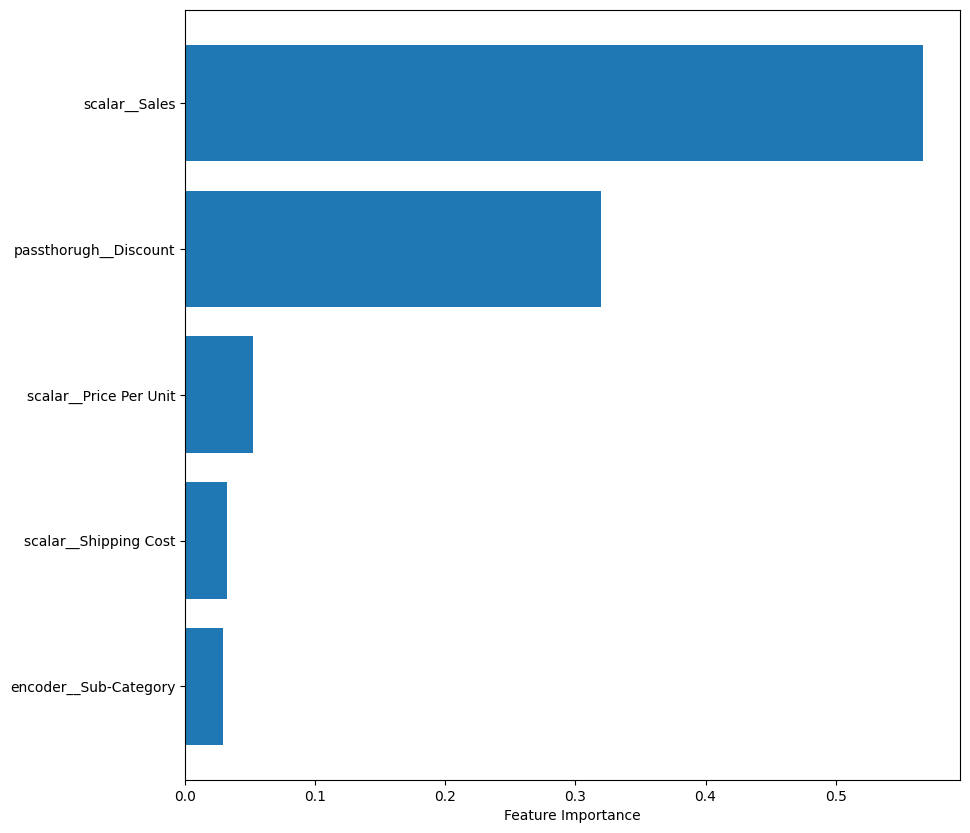

In [132]:
importance = model_profit.named_steps["regressor"].feature_importances_
features = model_profit.named_steps["ct"].get_feature_names_out()
feature_imp = pd.DataFrame(importance, features, columns=["Importance"])
feature_imp = feature_imp.sort_values("Importance", ascending=True)

plt.figure(figsize=(10, 10))
plt.barh(feature_imp.index, feature_imp["Importance"])
plt.xlabel("Feature Importance")
plt.show()

# Classifier

In [113]:
# Classifier Data
dfs = data.copy()
dfs = dfs[['Order Priority', 'Market', 'Segment', 'Category', 'Sub-Category', 'Region', 'City', 'Country', 'State',
           'Quantity', 'Discount', 'Sales', 'Shipping Cost', 'Profit',
           'Price Per Unit', 'Ship Delay', 'Ship Date Day', 'Order Date Day',
           'Ship Date Month', 'Order Date Month', 'Ship Date Absolute', 'Ship Mode']]
dfs.head()

,Order Priority,Market,Segment,Category,Sub-Category,Region,City,Country,State,Quantity,...,Shipping Cost,Profit,Price Per Unit,Ship Delay,Ship Date Day,Order Date Day,Ship Date Month,Order Date Month,Ship Date Absolute,Ship Mode
0,Critical,US,Consumer,Technology,Accessories,East,New York City,United States,New York,7,...,933.57,762.1850,329.950000,0,213,213,7,7,734715,Same Day
1,Critical,US,Consumer,Furniture,Tables,East,New York City,United States,New York,7,...,348.18,-290.8750,155.825714,0,213,213,7,7,734715,Same Day
2,Critical,US,Consumer,Office Supplies,Paper,East,New York City,United States,New York,3,...,7.24,9.3312,6.480000,0,213,213,7,7,734715,Same Day
3,Critical,APAC,Corporate,Technology,Copiers,Oceania,Wollongong,Australia,New South Wales,2,...,65.35,34.4220,172.341000,2,38,36,2,2,734904,Second Class
4,Critical,APAC,Corporate,Office Supplies,Storage,Oceania,Wollongong,Australia,New South Wales,5,...,41.64,-6.0300,26.784000,2,38,36,2,2,734904,Second Class


In [114]:
from sklearn.model_selection import train_test_split

x_shipping = dfs.drop(["Ship Mode"], axis=1)
y_shipping = dfp["Ship Mode"]

xs_train, xs_test, ys_train, ys_test = train_test_split(x_shipping, y_shipping, test_size=0.2, random_state=42)

0.663529743815097


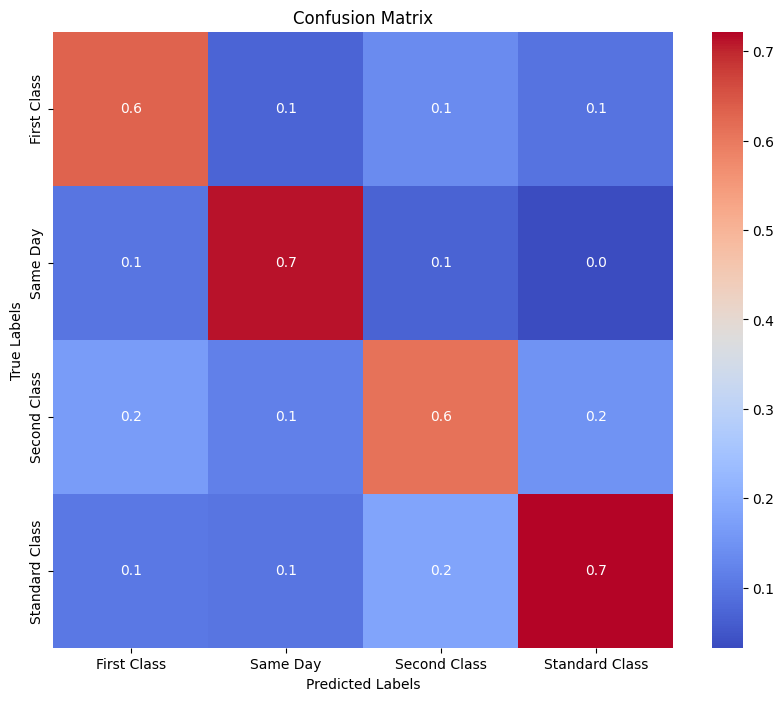

In [149]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

cts = ColumnTransformer([
    ("ordinal", OrdinalEncoder(), ['Order Priority', 'Market', 'Segment', 'Category', 'Sub-Category', 'Region']),
    ("target", TargetEncoder(), ['City', 'Country', 'State']),
    ("scalar", StandardScaler(), ['Sales', 'Profit', 'Price Per Unit']),
    ("passthorugh", 'passthrough', ["Discount", "Quantity", 'Order Date Day', 'Order Date Month'])
])

model_shipping = Pipeline(steps=[
    ("ct", cts),
 #   ("pca", PCA(n_components=9)),
    ("classifier", RandomForestClassifier(n_jobs=-1, n_estimators=400))
])

model_shipping.fit(xs_train, ys_train)

F1 score: 0.663529743815097
Accuracy score: 0.7023354137306221
Recall score: 0.7023354137306221
Precision score: 0.6860637629459151


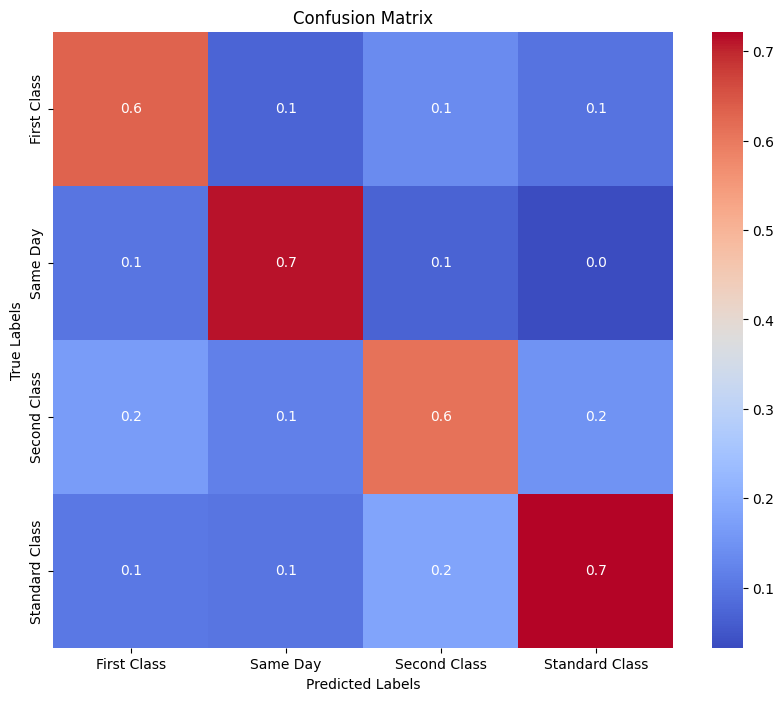

In [157]:
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns

ys_pred = model_shipping.predict(xs_test)
labels = model_shipping.named_steps["classifier"].classes_
f1_shipping = f1_score(ys_test, ys_pred, average='weighted')
accuracy_shipping = accuracy_score(ys_test, ys_pred)
recall_shipping = recall_score(ys_test, ys_pred, average='weighted')
precision_shipping = precision_score(ys_test, ys_pred, average='weighted')
confusion_shipping = confusion_matrix(ys_test, ys_pred, normalize='pred')

plt.figure(figsize=(10,8))
sns.heatmap(confusion_shipping, annot=True, fmt= ".1f", cmap="coolwarm", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
print(f"F1 score: {f1_shipping}")
print(f"Accuracy score: {accuracy_shipping}")
print(f"Recall score: {recall_shipping}")
print(f"Precision score: {precision_shipping}")

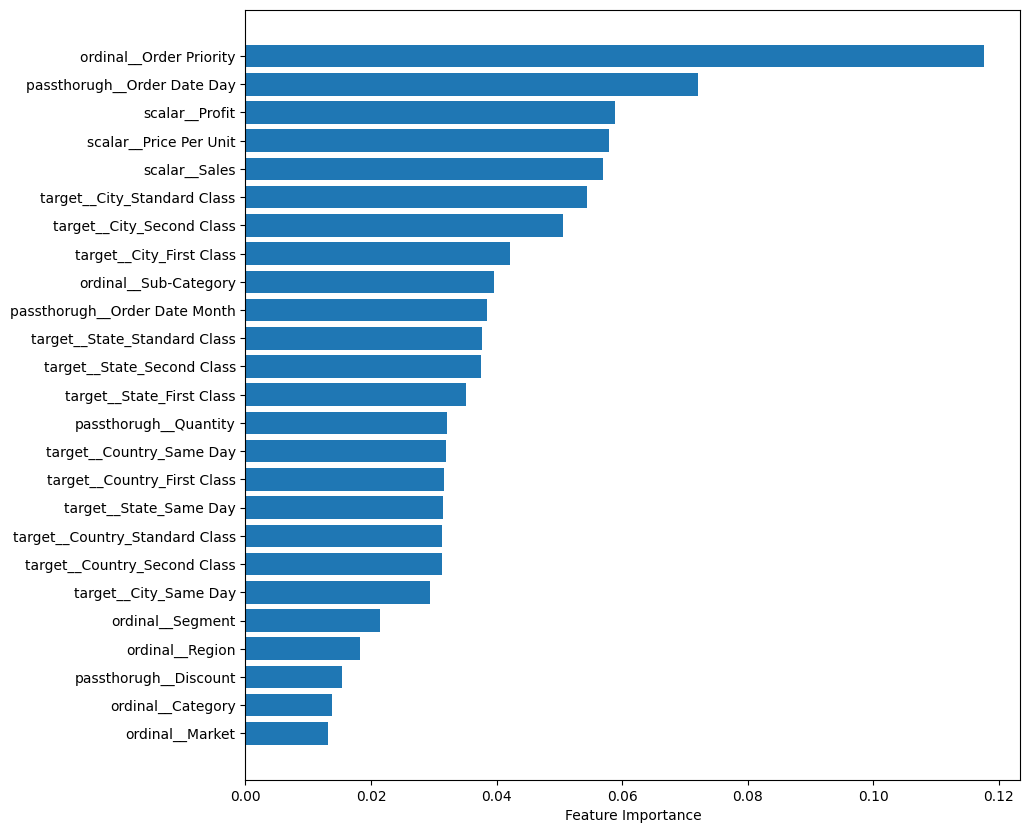

In [148]:
importance = model_shipping.named_steps["classifier"].feature_importances_
features = model_shipping.named_steps["ct"].get_feature_names_out()
feature_imp = pd.DataFrame(importance, features, columns=["Importance"])
feature_imp = feature_imp.sort_values("Importance", ascending=True)

plt.figure(figsize=(10, 10))
plt.barh(feature_imp.index, feature_imp["Importance"])
plt.xlabel("Feature Importance")
plt.show()